# Calibration of the Chaboche mecanical model with bayesian methods

## Deterministic model

The Chaboche mecanical law predicts the stress depending on the strain:
$$
\sigma = g(\epsilon,R,C,\gamma) = R + \frac{C}{\gamma} (1-\exp(-\gamma\epsilon))
$$

where:

- $\epsilon$ is the strain,
- $\sigma$ is the stress (Pa),
- $R$, $C$, $\gamma$ are the parameters.

Caution: 
* The strain $\epsilon$ is not the random error of the least squares model. 
* The stress $\sigma$ is not the standard deviation of the random noise of the output observations.


## Parameters to calibrate

The vector of parameters to calibrate is: 
$$
\boldsymbol{\theta} = (R,C,\gamma).
$$

The true values of the parameters are:

- $R = 750\times 10^6$ (Pa),
- $C = 2750\times 10^6$ (Pa),
- $\gamma = 10$.


## Observations

We assume the observed constraint has a Gaussian distribution:

$$
\epsilon_\sigma \sim \mathcal{N} \left(0, \sigma_\epsilon^2\right)
$$

where $\sigma_\epsilon > 0$ is unknown.
We make the hypothesis that the observation errors are independent.
We are given $n = 10$ observations.
We consider a Monte-Carlo sample with size $n$:

$$
\sigma^{(i)} = g\left(\epsilon^{(i)},R,C,\gamma\right) + \left(\epsilon_\sigma\right)^{(i)}, 
$$

for $i \in \{1,..., n\}$.
The observations are the pairs $\left\{\left(\epsilon^{(i)},\sigma^{(i)}\right)\right\}_{1 \leq i \leq n}$, i.e. each observation is a couple made of the strain and the corresponding stress.



## Thanks to

- Antoine Dumas, Phimeca


## References

- J. Lemaitre and J. L. Chaboche (2002) "Mechanics of solid materials" Cambridge University Press.

## Mise à l'échelle
Une difficulté pratique de ce modèle est que l'ordre de grandeur d'une contrainte est en méga Pascal c'est-à-dire $10^6$ Pa. Ces valeurs numériques sont bien plus grandes que la déformation dont l'ordre de grandeur est égal à $10^{-2}$. Cela complique plusieurs étapes dans l'analyse :
- dans le paramétrage du modèle :
	- dans Persalys, la mise en œuvre utilise des nombres avec un grand nombre de zéros,
	- le choix du pas de différentiation est moins facile (voir la suite pour plus de détails sur ce sujet),
- dans le traitement des résultats, les graphiques et les valeurs numériques sont peu commodes.

Dans le but de faciliter le travail, nous considérons par la suite des contraintes en MPa. On rappelle que 1 MPa = $10^6$ Pa, et que "Pa" est l'abbréviation de Pascal. 


In [1]:
import numpy as np
import openturns as ot
import openturns.viewer as otv
import pylab as pl
from openturns.usecases import chaboche_model
import tabulate

## Load the observations

Load the Chaboche model

In [2]:
cm = chaboche_model.ChabocheModel()

See the dataset.

In [3]:
cm.data

,Strain,Stress (Pa)
0,0,7.56e+08
1,0.0077,7.57e+08
2,0.0155,7.85e+08
3,0.0233,8.19e+08
4,0.0311,8.01e+08
5,0.0388,8.42e+08
6,0.0466,8.49e+08
7,0.0544,8.79e+08
8,0.0622,8.85e+08
9,0.07,8.96e+08


Load the observed stress data.

In [4]:
observedStress = cm.data[:, 1]
observedStress /= 1.0e6
observedStress.setDescription(["Stress (MPa)"])
observedStress

,Stress (MPa)
0,756
1,757
2,785
3,819
4,801
5,842
6,849
7,879
8,885
9,896


Load the sample of observed strains. 

In [5]:
observedStrain = cm.data[:, 0]
observedStrain

,Strain
0,0
1,0.0077
2,0.0155
3,0.0233
4,0.0311
5,0.0388
6,0.0466
7,0.0544
8,0.0622
9,0.07


See the data.

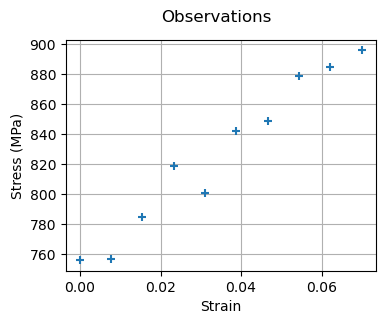

In [6]:
graph = ot.Graph("Observations", "Strain", "Stress (MPa)", True)
cloud = ot.Cloud(observedStrain, observedStress)
graph.add(cloud)
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Notice that the output stress depends almost linearily on the strain. We will see later that the actual model has a small but significant nonlinearity. The vertical deviation of the points from this curve depends on the observation noise.  

## Define the model

Create the Python function.

In [7]:
def modelChaboche(X):
    strain, R, C, gamma = X
    R *= 1.0e6  # Convert to Pa
    C *= 1.0e6  # Convert to Pa
    stress = R + C * (1.0 - np.exp(-gamma * strain)) / gamma
    stress /= 1.0e6  # Convert into Mpa
    return [stress]


g = ot.PythonFunction(4, 1, modelChaboche)
g.setInputDescription(["Strain", "R", "C", "Gamma"])
g.setOutputDescription(["Stress"])
g

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[Strain,R,C,Gamma,Stress] evaluationImplementation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[Strain,R,C,Gamma,Stress] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=4 values=[0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=OpenTURNSPythonFunction description=[x0,x1,x2,x3,y0] parameter=class=Point name=Unnamed dimension=0 values=[]

## Set the calibration parameters

The true value of the parameters.

In [8]:
R_True = 750.0  # MPa
C_True = 2750.0  # MPa
gamma_True = 10.0

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [9]:
R = 700.0  # (MPa) Exact : 750
C = 2500.0  # (MPa) Exact : 2750
Gamma = 8.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

The following statement create the calibrated function from the model. The calibrated parameters R, C, Gamma are at indices 1, 2, 3 in the inputs arguments of the model.

In [10]:
calibratedIndices = [1, 2, 3]
mycf = ot.ParametricFunction(g, calibratedIndices, thetaPrior)

## Gaussian calibration parameters

The standard deviation of the observations errors. In general, this value is unknown and must be guessed. In this example we use the same value as the true value.

In [11]:
sigmaStress = 10.0  # (MPa) (true value : 10.0)

Define the covariance matrix of the output Y of the model. In this particular case, the observation error is assumed to be constant across the observations. Hence, we provide only a single covariance matrix with dimension 1: this matrix will be used for all observations. This is the *local* way to define the covariance matrix of the observation errors.

In [12]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0, 0] = sigmaStress**2

Define the covariance matrix of the parameters $\theta$ to calibrate. We use here a diagonal covariance matrix (but a more general matrix could be used as well if this matches the prior information).

In [13]:
sigmaPriorR = 0.1 * R
sigmaPriorC = 0.1 * C
sigmaPriorGamma = 0.1 * Gamma

In [14]:
thetaPriorCovariance = ot.CovarianceMatrix(3)
thetaPriorCovariance[0, 0] = sigmaPriorR**2
thetaPriorCovariance[1, 1] = sigmaPriorC**2
thetaPriorCovariance[2, 2] = sigmaPriorGamma**2
thetaPriorCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4900,0,0,0,62500,0,0,0,0.64]

## Gaussian linear calibration

The `GaussianLinearCalibration` class performs the gaussian linear calibration by linearizing the model in the neighbourhood of the prior.

In [15]:
algo = ot.GaussianLinearCalibration(
    mycf,
    observedStrain,
    observedStress,
    thetaPrior,
    thetaPriorCovariance,
    errorCovariance,
)

The `run` method computes the solution of the problem.

In [16]:
algo.run()
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [17]:
thetaMAP_GL = calibrationResult.getParameterMAP()
thetaMAP_GL

class=Point name=Unnamed dimension=3 values=[748.47,2690.61,7.77893]

We can compute a 95% credibility interval of the parameter $\boldsymbol{\theta}^\star$ (this is not a confidence interval because we are in a Bayesian setting). 

In [18]:
thetaPosterior_GL = calibrationResult.getParameterPosterior()
confidenceLevel = 0.95
credibilityIntervalTheta_GL = (
    thetaPosterior_GL.computeBilateralConfidenceIntervalWithMarginalProbability(
        confidenceLevel
    )[0]
)
print(f"{100 * confidenceLevel:.0f}% Credibility interval for theta :")
print(credibilityIntervalTheta_GL)

95% Credibility interval for theta :
[735.992, 760.948]
[2330.73, 3050.49]
[5.95375, 9.60411]


We can see that the $R$ parameter (the first one) has a relalively small confidence interval. By contrast, the $\gamma$ parameter (the third one) is estimated with a large confidence interval.

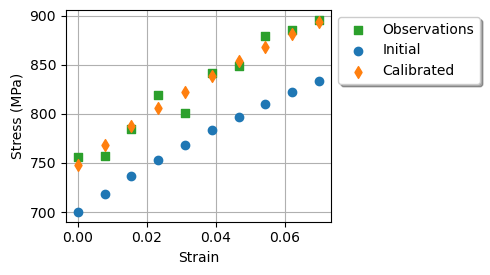

In [19]:
graph = calibrationResult.drawObservationsVsInputs().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

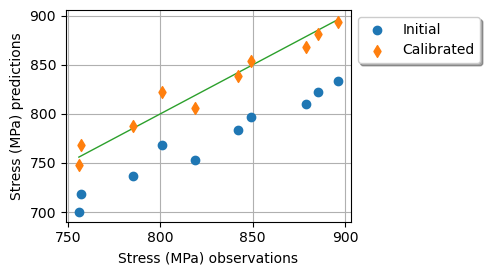

In [20]:
graph = calibrationResult.drawObservationsVsPredictions().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by linearizing the problem at the prior. 

In [21]:
observationError = calibrationResult.getObservationsError()
print(observationError)

Normal(mu = 0, sigma = 10)


This can be compared to the residuals distribution, which is computed at the posterior.

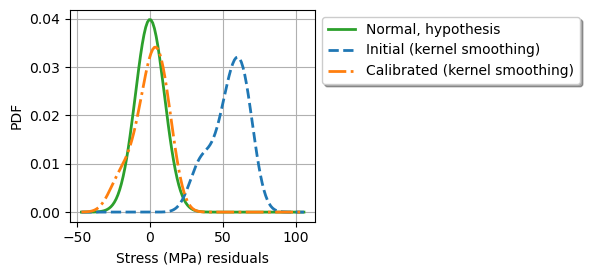

In [22]:
graph = calibrationResult.drawResiduals().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (6.0, 3.0)})

**Analysis.**

- Before calibration, the red curve indicates that the distribution of the residuals is centered on the stress value $\sigma=5$, which is far from zero. This indicates that residuals are positive before calibration, which shows a poor fit. 
- The analysis of the distribution of the residuals (the green line) shows that the distribution is centered on zero and almost symmetric. This indicates that the calibration performed well. 
- The blue line presents the Gaussian distribution which has zero mean and which standard deviation is computed from the residuals. We see that the green line (after calibration) is close to the blue line, which implies that the distribution of the residuals is close to being gaussian. This implies that the Gaussian hypothesis of the residuals is validated. Therefore, the confidence intervals of $\boldsymbol{\theta}^\star$ can be trusted. 

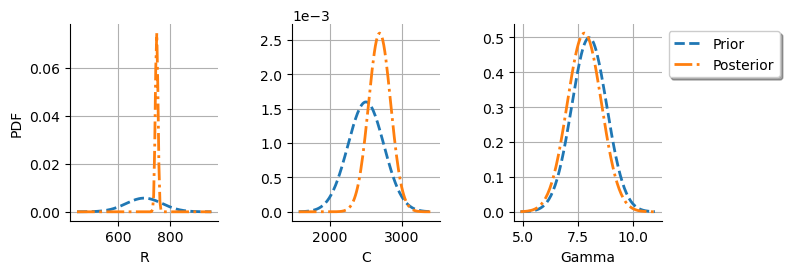

In [23]:
graph = calibrationResult.drawParameterDistributions()
otv.View(
    graph,
    figure_kw={"figsize": (8.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = pl.subplots_adjust(wspace=0.5)

**Analysis.**
- The figure on the left presents the distribution of the $R$ variable. The blue curve is the prior, which is almost flat. The orange curve is the posterior distribution of $R$, which is spiky and centered on $R=749.9\times 10^8$. Since the prior and posterior distributions are very different for the $R$ parameter, this implies that the observations have more weight on this parameter than the prior distibution. 
- On the right plot, we see that the prior and posterior distribution are close to each other for the $\gamma$ variable: the observations did not convey much information for this variable and the prior distribution $\gamma$ has more weight.
- The center plot for the $C$ parameter is intermediate: the observations have decreased the variance of the estimation, but it remains relatively close to the prior. 

## Gaussian nonlinear calibration

The `GaussianNonLinearCalibration` class performs the gaussian nonlinear calibration.

In [24]:
algo = ot.GaussianNonLinearCalibration(
    mycf,
    observedStrain,
    observedStress,
    thetaPrior,
    thetaPriorCovariance,
    errorCovariance,
)

The `run` method computes the solution of the problem.

In [25]:
algo.run()
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [26]:
thetaMAP_GNL = calibrationResult.getParameterMAP()
thetaMAP_GNL

class=Point name=Unnamed dimension=3 values=[748.445,2689.51,7.7628]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [27]:
thetaPosterior_GNL = calibrationResult.getParameterPosterior()
confidenceLevel = 0.95
credibilityIntervalTheta_GNL = (
    thetaPosterior_GNL.computeBilateralConfidenceIntervalWithMarginalProbability(
        confidenceLevel
    )[0]
)
print(f"{100 * confidenceLevel:.0f}% Credibility interval for theta :")
print(credibilityIntervalTheta_GNL)

95% Credibility interval for theta :
[732.075, 759.328]
[2466.01, 3021.4]
[7.37248, 7.91358]


As before, we can see that the $R$ parameter (the first one) has a relalively small confidence interval. The $\gamma$ parameter (the third one) is estimated with a large confidence interval, but smaller than in the linear case.

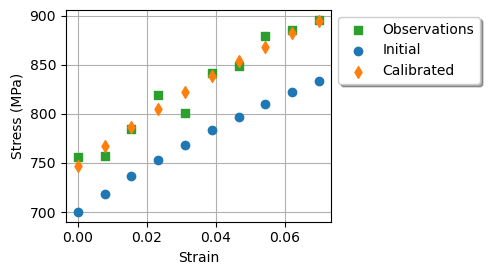

In [28]:
graph = calibrationResult.drawObservationsVsInputs().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

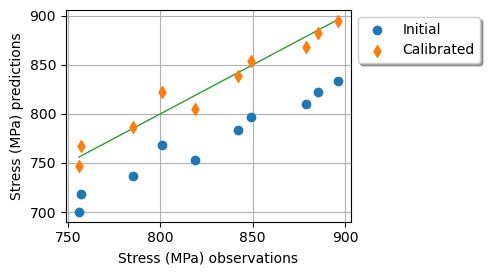

In [29]:
graph = calibrationResult.drawObservationsVsPredictions().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by bootstraping the problem at the posterior. 

In [30]:
observationError = calibrationResult.getObservationsError()
print(observationError)

Normal(mu = -0.0988678, sigma = 10)


This can be compared to the residuals distribution, which is computed at the posterior.

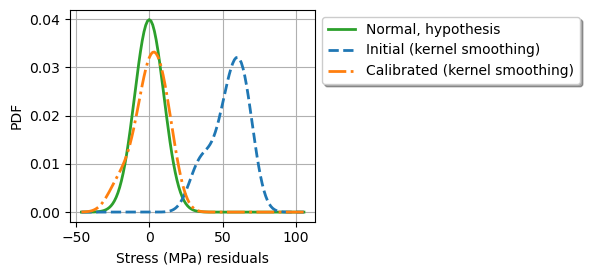

In [31]:
graph = calibrationResult.drawResiduals().getGraph(0, 0)
graph.setLegendPosition("topleft")
graph.setLegendCorner((1.0, 1.0))
_ = otv.View(graph, figure_kw={"figsize": (6.0, 3.0)})

The analysis of the distribution of the residuals (the blue line) shows that the distribution is approximately centered on zero and symmetric. This indicates that the calibration performed well. Moreover, the distribution of the residuals is close to being Gaussian.

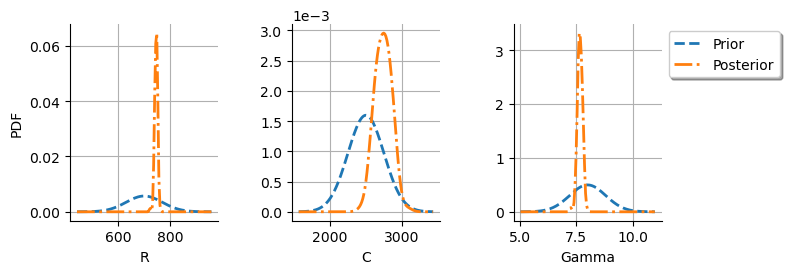

In [32]:
graph = calibrationResult.drawParameterDistributions()
otv.View(
    graph,
    figure_kw={"figsize": (8.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = pl.subplots_adjust(wspace=0.5)

**Caution.** In the Gaussian non linear case, the posterior distribution is, in general, unknown. In particular, there is no reason to get a Gaussian posterior distribution, even if the prior distribution is Gaussian. If we want the actual posterior distribution, we have to use either an extra hypothesis. For example, we may assume that the parametric model is linear with respect to the parameters, which turns out to the Gaussian linear calibration. Another option would be to use MCMC sampling. If the `GaussianNonLinearCalibration-BootstrapSize` key of the `ResourceMap` is non zero (which is the default), the `GaussianNonLinearCalibration` class measures the sensitivity of the MAP optimum to the variability in the observed sample.

**Analysis.**
- The distribution of R is very spiky compared to the relatively flat prior. This implies that the observations have brought a very significant information on the parameter R: the MAP is not very sensitive to the variability in the observed sample because the parameter R is highly influential. Hence, calibrating R is relatively easy with Gaussian non linear calibration.
- We see that the prior and posterior distribution are close to each other for C, but not superimposed: the observations significantly brought information during the calibration. 
- For the parameter Gamma, the distribution of the MAP is spiky: the variability of the MAP estimator of Gamma is small. The MAP estimator of Gamma is not very sensitive to the variability in the observed sample. This is because the parameter Gamma is difficult do identify so that it remains close to the prior value of the parameter C. The prior weighs more than the data for the parameter Gamma. This is a very different conclusion than the one brought by the Gaussian linear calibration.


In [33]:
defaultBootstrapSize = ot.ResourceMap.GetAsUnsignedInteger(
    "GaussianNonLinearCalibration-BootstrapSize"
)
print(defaultBootstrapSize)

100


We see that the default value of the "GaussianNonLinearCalibration-BootstrapSize" key is 100. This means that the "posterior" distribution is computed based on 100 bootstrap re-samples of the estimator $\widehat{\boldsymbol{\theta}}$. Then the library uses kernel smoothing to approximate the distribution.

If the `"GaussianNonLinearCalibration-BootstrapSize"` key is set to zero, then the method to compute the posterior distribution is different. In this case, the method linearizes the model at the MAP, then compute the posterior distribution assuming the model is linear. In this case, the distribution is a true posterior distribution, but with a linear model which is an approximation of the true model. This is called "Laplace's approximation" in the Bayesian setting.

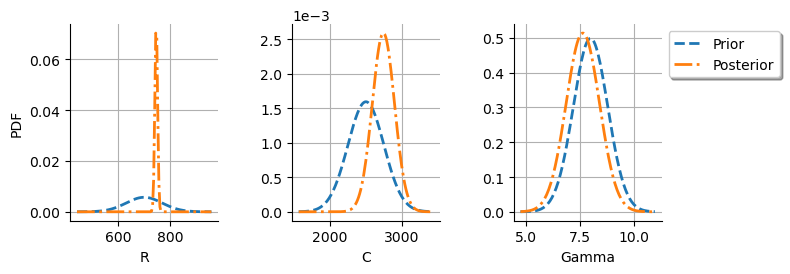

In [34]:
# See the effect of Laplace's approximation
ot.ResourceMap.SetAsUnsignedInteger("GaussianNonLinearCalibration-BootstrapSize", 0)
algo = ot.GaussianNonLinearCalibration(
    mycf,
    observedStrain,
    observedStress,
    thetaPrior,
    thetaPriorCovariance,
    errorCovariance,
)
algo.run()
calibrationResult = algo.getResult()
graph = calibrationResult.drawParameterDistributions()
otv.View(
    graph,
    figure_kw={"figsize": (8.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = pl.subplots_adjust(wspace=0.5)
# Reset the ResourceMap key
ot.ResourceMap.SetAsUnsignedInteger(
    "GaussianNonLinearCalibration-BootstrapSize", defaultBootstrapSize
)

We see that the results are more consistent with the results from linear Gaussian calibration. 

## Synthèse

In [35]:
# Get the bounds of the confidence intervals.
thetaLower_GL = credibilityIntervalTheta_GL.getLowerBound()
thetaUpper_GL = credibilityIntervalTheta_GL.getUpperBound()
thetaLower_GNL = credibilityIntervalTheta_GNL.getLowerBound()
thetaUpper_GNL = credibilityIntervalTheta_GNL.getUpperBound()

data = [
    ["Vrai", R_True, C_True, gamma_True, "", "", ""],
    ["Moyen", thetaPrior[0], thetaPrior[1], thetaPrior[2], "", "", ""],
    [
        "GL",
        thetaMAP_GL[0],
        thetaMAP_GL[1],
        thetaMAP_GL[2],
        f"[{thetaLower_GL[0]:.1f}, {thetaUpper_GL[0]:.1f}]",
        f"[{thetaLower_GL[1]:.0f}, {thetaUpper_GL[1]:.0f}]",
        f"[{thetaLower_GL[2]:.3f}, {thetaUpper_GL[2]:.3f}]",
    ],
    [
        "GNL",
        thetaMAP_GNL[0],
        thetaMAP_GNL[1],
        thetaMAP_GNL[2],
        f"[{thetaLower_GNL[0]:.1f}, {thetaUpper_GNL[0]:.1f}]",
        f"[{thetaLower_GNL[1]:.0f}, {thetaUpper_GNL[1]:.0f}]",
        f"[{thetaLower_GNL[2]:.3f}, {thetaUpper_GNL[2]:.3f}]",
    ],
]
tabulate.tabulate(
    data,
    headers=[
        "",
        "R (MPa)",
        "C (MPa)",
        "Gamma",
        "R interval",
        "C interval",
        "Gamma interval",
    ],
    tablefmt="html",
)

,R (MPa),C (MPa),Gamma,R interval,C interval,Gamma interval
Vrai,750,2750,10,,,
Moyen,700,2500,8,,,
GL,748.47,2690.61,7.77893,"[736.0, 760.9]","[2331, 3050]","[5.954, 9.604]"
GNL,748.445,2689.51,7.7628,"[732.1, 759.3]","[2466, 3021]","[7.372, 7.914]"


## Exercice 1 : changement du paramètre de référence

L'objectif de cette question est d'observer l'impact du changement du paramètre de référence, c'est-à-dire du vecteur moyen de la loi gaussienne _a priori_.

**Questions.**
* Changer le paramètre `thetaPrior` et utiliser les valeurs numériques suivantes :

In [36]:
R = 650.0  # Exact : 750
C = 2300.0  # Exact : 2750
Gamma = 6.0  # Exact : 10
thetaPrior = ot.Point([R, C, Gamma])

* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien linéaire ? Pouvez-vous expliquer les causes de ces différences ?
* Comment évolue la valeur du paramètre optimal dans le cas du calage gaussien non-linéaire ? Pouvez-vous expliquer les causes de ces différences ?

## Exercice 2 : changement de la matrice de covariance a priori

Dans cette question, on considère la méthode de calage gaussien linéaire.

**Questions.**
* Changer le paramètre `thetaPriorCovariance` et utiliser les valeurs numériques suivantes :

In [37]:
coefficientOfVariation = 0.5
sigmaPriorR = coefficientOfVariation * R
sigmaPriorC = coefficientOfVariation * C
sigmaPriorGamma = coefficientOfVariation * Gamma

In [38]:
thetaPriorCovariance = ot.CovarianceMatrix(3)
thetaPriorCovariance[0, 0] = sigmaPriorR**2
thetaPriorCovariance[1, 1] = sigmaPriorC**2
thetaPriorCovariance[2, 2] = sigmaPriorGamma**2
thetaPriorCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[105625,0,0,0,1.3225e+06,0,0,0,9]

* Dessiner la loi _a posteriori_. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?
* Changer le paramètre `sigma` et utiliser les valeurs numériques suivantes :

In [39]:
coefficientOfVariation = 0.01
sigmaPriorR = coefficientOfVariation * R
sigmaPriorC = coefficientOfVariation * C
sigmaPriorGamma = coefficientOfVariation * Gamma

In [40]:
thetaPriorCovariance = ot.CovarianceMatrix(3)
thetaPriorCovariance[0, 0] = sigmaPriorR**2
thetaPriorCovariance[1, 1] = sigmaPriorC**2
thetaPriorCovariance[2, 2] = sigmaPriorGamma**2
thetaPriorCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[42.25,0,0,0,529,0,0,0,0.0036]

* Dessiner la loi _a posteriori_. 
* Quels sont les changements dans les lois ? Pouvez-vous expliquer ces changements ?
* Faire de même avec le calage gaussien non-linéaire.

## Exercice 3 : changement de la covariance du bruit d'observation

**Questions.**

* Définir les valeurs suivantes du bruit d'observation.

In [41]:
sigmaStress = 10.0  # (MPa) Valeur de référence
sigmaStress = 100.0  # (MPa) Nouvelle valeur 1
sigmaStress = 1000.0  # (MPa) Nouvelle valeur 2

* Pour le calage gaussien linéaire, dessiner les lois _a priori_ et _a posteriori_. 
* Quels sont les changements ? Pouvez-vous expliquer ces changements ?

## Exercice 4 : Dessiner la loi des paramètres après calage

On souhaite dessiner la densité de probabilité des paramètres après calage et observer une éventuelle dépendance entre les variables.

**Questions.**
- Pour la loi des paramètres après calage par calage gaussien linéaire, utiliser la fonction `plotDistributionGridPDF()` pour dessiner les iso-valeurs de la densité de probabilité. Qu'observez-vous ?
- Ré-itérer l'exercice pour la loi des paramètres après calage par calage gaussien non linéaire. Qu'observez-vous ?

In [42]:
def plotDistributionGridPDF(distribution):
    """
    Plot the marginal and bi-dimensional iso-PDF on a grid.

    Parameters
    ----------
    distribution : ot.Distribution
        The distribution.

    Returns
    -------
    grid : ot.GridLayout(dimension, dimension)
        The grid of plots.

    """
    dimension = distribution.getDimension()
    grid = ot.GridLayout(dimension, dimension)
    for i in range(dimension):
        for j in range(dimension):
            if i == j:
                distributionI = distribution.getMarginal([i])
                graph = distributionI.drawPDF()
            else:
                distributionJI = distribution.getMarginal([j, i])
                graph = distributionJI.drawPDF()
            graph.setLegends([""])
            graph.setTitle("")
            if i < dimension - 1:
                graph.setXTitle("")
            if j > 0:
                graph.setYTitle("")
            grid.setGraph(i, j, graph)
    grid.setTitle("Iso-PDF values")
    return grid